# `nsgaiii`: Understanding NSGA-III with a Python Implementation

In this notebook we will explore NSGA-III and introduce its implementation in Python, that is distributed as the [`nsgaiii` module]

## Preparing the environment

In [1]:
import time, array, random, copy, math
from itertools import chain
from operator import attrgetter, itemgetter

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np

In case you want to run this notebook on your own you need IPython and the [DEAP evolutionary computation module](https://www.github.com/DEAP/deap) with version 1.1.0 or above (at the time of writing this version is only available by cloning it from the GitHub repository).

In [3]:
from deap import algorithms, base, benchmarks, tools, creator

In [4]:
from custom import *

Version of the modules used. Go to https://github.com/jrjohansson/version_information to install extension. 

# `nsgaiii` source code

We start by loading and inspecting the source code of the module. As we want to play with we will load all the supporting methods that otherwise would remain hidden after the `import` statement.

In [5]:
# %load nsgaiii/selection.py
#    This file is part of nsgaiii, a Python implementation of NSGA-III.
#
#    nsgaiii is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    nsgaiii is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with nsgaiii. If not, see <http://www.gnu.org/licenses/>.
#
#    by Luis Marti (IC/UFF) http://lmarti.com

import copy,random
import numpy as np
from deap import tools

class ReferencePoint(list):
    '''A reference point exists in objective space an has a set of individuals
    associated to it.'''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.associations_count = 0
        self.associations = []

def generate_reference_points(num_objs, num_divisions_per_obj=4):
    '''Generates reference points for NSGA-III selection. This code is based on
    `jMetal NSGA-III implementation <https://github.com/jMetal/jMetal>`_.
    '''
    def gen_refs_recursive(work_point, num_objs, left, total, depth):
        if depth == num_objs - 1:
            work_point[depth] = left/total
            ref = ReferencePoint(copy.deepcopy(work_point))
            return [ref]
        else:
            res = []
            for i in range(left):
                work_point[depth] = i/total
                res = res + gen_refs_recursive(work_point, num_objs, left-i, total, depth+1)
            return res
    return gen_refs_recursive([0]*num_objs, num_objs, num_objs*num_divisions_per_obj,
                              num_objs*num_divisions_per_obj, 0)

def find_ideal_point(individuals):
    'Finds the ideal point from a set individuals.'
    current_ideal = [np.infty] * len(individuals[0].fitness.values)
    for ind in individuals:
        # Use wvalues to accomodate for maximization and minimization problems.
        current_ideal = np.minimum(current_ideal, 
                                  np.multiply(ind.fitness.wvalues, -1))
    return current_ideal

def find_extreme_points(individuals):
    'Finds the individuals with extreme values for each objective function.'
    return [sorted(individuals, key=lambda ind:ind.fitness.wvalues[o] * -1)[-1]
            for o in range(len(individuals[0].fitness.values))]

def construct_hyperplane(individuals, extreme_points):
    'Calculates the axis intersects for a set of individuals and its extremes.'
    def has_duplicate_individuals(individuals):
        for i in range(len(individuals)):
            for j in range(i+1, len(individuals)):
                if individuals[i].fitness.values == individuals[j].fitness.values:
                    return True
        return False

    num_objs = len(individuals[0].fitness.values)

    if has_duplicate_individuals(extreme_points):
        intercepts = [extreme_points[m].fitness.values[m] for m in range(num_objs)]
    else:
        b = np.ones(num_objs)
        A = [point.fitness.values for point in extreme_points]
        x = np.linalg.solve(A,b)
        intercepts = 1/x
    return intercepts

def normalize_objective(individual, m, intercepts, ideal_point, epsilon=1e-20):
    'Normalizes an objective.'
    # Numeric trick present in JMetal implementation.
    if np.abs(intercepts[m]-ideal_point[m] > epsilon):
        return individual.fitness.values[m] / (intercepts[m]-ideal_point[m])
    else:
        return individual.fitness.values[m] / epsilon

def normalize_objectives(individuals, intercepts, ideal_point):
    '''Normalizes individuals using the hyperplane defined by the intercepts as
    reference. Corresponds to Algorithm 2 of Deb & Jain (2014).'''
    num_objs = len(individuals[0].fitness.values)

    for ind in individuals:
        ind.fitness.normalized_values = list([normalize_objective(ind, m,
                                                                  intercepts, ideal_point)
                                                                  for m in range(num_objs)])
    return individuals

def perpendicular_distance(direction, point):
    k = np.dot(direction, point) / np.sum(np.power(direction, 2))
    d = np.sum(np.power(np.subtract(np.multiply(direction, [k] * len(direction)), point) , 2))
    return np.sqrt(d)

def associate(individuals, reference_points):
    '''Associates individuals to reference points and calculates niche number.
    Corresponds to Algorithm 3 of Deb & Jain (2014).'''
    pareto_fronts = tools.sortLogNondominated(individuals, len(individuals))
    num_objs = len(individuals[0].fitness.values)

    for ind in individuals:
        rp_dists = [(rp, perpendicular_distance(ind.fitness.normalized_values, rp))
                    for rp in reference_points]
        best_rp, best_dist = sorted(rp_dists, key=lambda rpd:rpd[1])[0]
        ind.reference_point = best_rp
        ind.ref_point_distance = best_dist
        best_rp.associations_count +=1 # update de niche number
        best_rp.associations += [ind]

def niching_select(individuals, k):
    '''Secondary niched selection based on reference points. Corresponds to
    steps 13-17 of Algorithm 1 and to Algorithm 4.'''
    if len(individuals) == k:
        return individuals

    #individuals = copy.deepcopy(individuals)

    ideal_point = find_ideal_point(individuals)
    extremes = find_extreme_points(individuals)
    intercepts = construct_hyperplane(individuals, extremes)
    normalize_objectives(individuals, intercepts, ideal_point)

    reference_points = generate_reference_points(len(individuals[0].fitness.values))

    associate(individuals, reference_points)

    res = []
    while len(res) < k:
        min_assoc_rp = min(reference_points, key=lambda rp: rp.associations_count)
        min_assoc_rps = [rp for rp in reference_points if rp.associations_count == min_assoc_rp.associations_count]
        chosen_rp = min_assoc_rps[random.randint(0, len(min_assoc_rps)-1)]

        #print('Rps',min_assoc_rp.associations_count, chosen_rp.associations_count, len(min_assoc_rps))

        associated_inds = chosen_rp.associations

        if chosen_rp.associations:
            if chosen_rp.associations_count == 0:
                sel = min(chosen_rp.associations, key=lambda ind: ind.ref_point_distance)
            else:
                sel = chosen_rp.associations[random.randint(0, len(chosen_rp.associations)-1)]
            res += [sel]
            chosen_rp.associations.remove(sel)
            chosen_rp.associations_count += 1
            individuals.remove(sel)
        else:
            reference_points.remove(chosen_rp)
    return res

def sel_nsga_iii(individuals, k):
    '''Implements NSGA-III selection as described in
    Deb, K., & Jain, H. (2014). An Evolutionary Many-Objective Optimization
    Algorithm Using Reference-Point-Based Nondominated Sorting Approach,
    Part I: Solving Problems With BoxConstraints. IEEE Transactions on
    Evolutionary Computation, 18(4), 577–601. doi:10.1109/TEVC.2013.2281535.
    '''
    assert len(individuals) >= k

    if len(individuals)==k:
        return individuals

    # Algorithm 1 steps 4--8
    fronts = tools.sortLogNondominated(individuals, len(individuals))

    limit = 0
    res =[]
    for f, front in enumerate(fronts):
        res += front
        if len(res) > k:
            limit = f
            break
    # Algorithm 1 steps
    selection = []
    if limit > 0:
        for f in range(limit):
            selection += fronts[f]

    # complete selected inividuals using the referece point based approach
    selection += niching_select(fronts[limit], k - len(selection))
    return selection

__all__ = ["sel_nsga_iii"]


# Understanding NSGA-III selection

In order to understand the NSGA-III selection mechanism we will make an example iteration of solving a three-objectives DTLZ2 problem.

In [6]:
creator.create("FitnessMin3", base.Fitness, weights=(-1.0,) * 3)
creator.create("Individual3", array.array, typecode='d', 
               fitness=creator.FitnessMin3)

The `toolbox` contains the configuration of the algorithm:

* how to create an individual,
* how to create a population,
* the evolutionary operators,
* the evaluation function, and
* the selection method.

The `prepare_toolbox()` function encapsulates the configuration.

In [7]:
def prepare_toolbox(problem_instance, selection_func, number_of_variables, bounds_low, bounds_up):
    
    def uniform(low, up, size=None):
        try:
            return [random.uniform(a, b) for a, b in zip(low, up)]
        except TypeError:
            return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]
    
    toolbox = base.Toolbox()
    
    toolbox.register('evaluate', problem_instance)
    toolbox.register('select', selection_func)
    
    toolbox.register("attr_float", uniform, bounds_low, bounds_up, number_of_variables)
    toolbox.register("individual", tools.initIterate, creator.Individual3, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                     low=bounds_low, up=bounds_up, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, 
                     low=bounds_low, up=bounds_up, eta=20.0, 
                     indpb=1.0/number_of_variables)

    toolbox.pop_size = 100   # population size
    toolbox.max_gen = 200    # max number of iteration
    toolbox.mut_prob = 1/number_of_variables
    toolbox.cross_prob = 0.3
    
    return toolbox

Preparing an instance of `toolbox`:

In [8]:
number_of_variables = 30

In [9]:
bounds_low, bounds_up = 0, 1

In [10]:
toolbox = prepare_toolbox(lambda ind: benchmarks.dtlz2(ind, 3), 
                          sel_nsga_iii, number_of_variables,
                          bounds_low, bounds_up)

## Visualizing refence point selection

Creating a population and evaluating it.

In [11]:
pop = toolbox.population(n=20)

In [12]:
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

ValueError: Supply a 'c' argument or a 'color' kwarg but not both; they differ but their functionalities overlap.

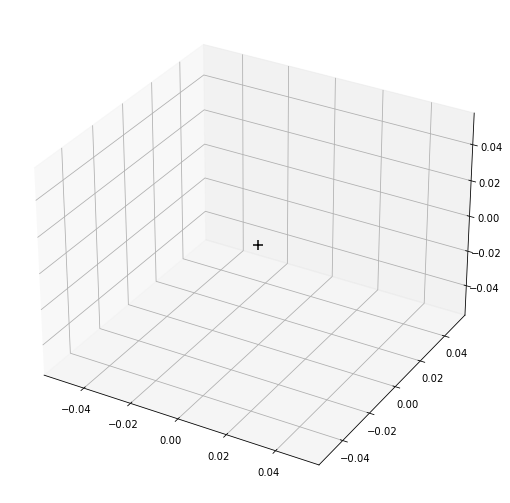

In [13]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin (black + sign)
ax.scatter(0,0,0, c='k', marker='+', s=100)

# the population (purple)
for ind in pop:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1], 
               ind.fitness.values[2], 
               color='purple', c='mediumpurple',
               s=30, marker='o')

# ideal point (red star)
ideal_point = find_ideal_point(pop)
ax.scatter(ideal_point[0], ideal_point[1], ideal_point[2],
           s=50, marker='*', color='salmon', c='red')

# extreme points marked (red)
extremes = find_extreme_points(pop)
for i,ex in enumerate(extremes):
    ax.scatter(ex.fitness.values[0],
               ex.fitness.values[1], 
               ex.fitness.values[2], s=30, c='r', marker='o', color='r')

# intercepts (in green)
intercepts = construct_hyperplane(pop, extremes)
verts = [(intercepts[0], 0, 0), (0, intercepts[1], 0), (0, 0, intercepts[2])]

for vert in verts:
    ax.scatter(vert[0], vert[1], vert[2], c='lightgreen', color='forestgreen', s=100, marker='.')
    
tri = a3.art3d.Poly3DCollection([verts])
tri.set_color('lightgreen')
tri.set_alpha(0.11)
tri.set_edgecolor('lightgreen')
ax.add_collection3d(tri)

# normalized objectives (light blue)
normalize_objectives(pop, intercepts, ideal_point)

for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2], color='navy', marker='o', c='lightblue')

# reference points (gray)
rps = generate_reference_points(3)
for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', c='lightgray', color='gray')

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=9, azim=-40)
plt.autoscale(tight=True)

Associating individuals to reference points.

In [ ]:
associate(pop, rps)

Resulting associations

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
ax.scatter(0,0,0, c='k', marker='+', s=100)

for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', c='lightgray', color='gray')

pairs = []
for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2], color='navy', marker='o', c='lightblue')
    pairs += [(ind.fitness.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('blue')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=11, azim=-21)
plt.autoscale(tight=True)

# Implementing NSGA-III

Having the selection mechanism the implementantion of NSGA-III is very simple thanks to DEAP.

In [ ]:
def nsga_iii(toolbox, stats=None, verbose=False):
    population = toolbox.population(n=toolbox.pop_size)
    return algorithms.eaMuPlusLambda(population, toolbox,
                              mu=toolbox.pop_size, 
                              lambda_=toolbox.pop_size, 
                              cxpb=toolbox.cross_prob, 
                              mutpb=toolbox.mut_prob,
                              ngen=toolbox.max_gen,
                              stats=stats, verbose=verbose)

We create a `Statistics` instance to store the populations in every iteration.

In [ ]:
stats = tools.Statistics()
stats.register('pop', copy.deepcopy)

Running NSGA-III...

In [ ]:
res, logbook = nsga_iii(toolbox, stats=stats)

Resulting population.

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for ind in res:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1],
               ind.fitness.values[2], c='purple', marker='o', color='mediumpurple')

ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=11, azim=-21)
plt.autoscale(tight=True)

### Plotting hypervolume

In [ ]:
pops = logbook.select('pop')

In [ ]:
from deap.tools._hypervolume import hv

In [ ]:
def hypervolume(individuals, ref=None):
    front = tools.sortLogNondominated(individuals, len(individuals), first_front_only=True)
    wobjs = np.array([ind.fitness.wvalues for ind in front]) * -1
    if ref is None:
        ref = np.max(wobjs, axis=0) + 1
    return hv.hypervolume(wobjs, ref)

In [ ]:
pops_obj = [np.array([ind.fitness.wvalues for ind in pop]) * -1 for pop in pops]

In [ ]:
ref = np.max([np.max(wobjs, axis=0) for wobjs in pops_obj], axis=0) + 1

In [ ]:
hypervols = [hypervolume(pop, ref) for pop in pops]

In [ ]:
plt.plot(hypervols)
plt.xlabel('Iterations (t)')
plt.ylabel('Hypervolume')
